# Stanford CS230 Traffic Sign Project

In [ ]:
!nvidia-smi

Sat Oct 24 17:51:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.2
torch 1.6.0+cu101
torchvision 0.7.0+cu101


In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Traffic Signs

We are using [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) which contains more than 50,000 annotated images of 40+ traffic signs.


In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-10-24 17:53:42--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  28.4MB/s    in 10s     

2020-10-24 17:53:53 (25.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



## Exploration

### Checking Folders and Files

In [20]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (165 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 144611 files and directories currently install

In [48]:
!tree GTSRB --filelimit=50

GTSRB
├── Final_Training
│   └── Images
│       ├── 00000 [211 entries exceeds filelimit, not opening dir]
│       ├── 00001 [2221 entries exceeds filelimit, not opening dir]
│       ├── 00002 [2251 entries exceeds filelimit, not opening dir]
│       ├── 00003 [1411 entries exceeds filelimit, not opening dir]
│       ├── 00004 [1981 entries exceeds filelimit, not opening dir]
│       ├── 00005 [1861 entries exceeds filelimit, not opening dir]
│       ├── 00006 [421 entries exceeds filelimit, not opening dir]
│       ├── 00007 [1441 entries exceeds filelimit, not opening dir]
│       ├── 00008 [1411 entries exceeds filelimit, not opening dir]
│       ├── 00009 [1471 entries exceeds filelimit, not opening dir]
│       ├── 00010 [2011 entries exceeds filelimit, not opening dir]
│       ├── 00011 [1321 entries exceeds filelimit, not opening dir]
│       ├── 00012 [2101 entries exceeds filelimit, not opening dir]
│       ├── 00013 [2161 entries exceeds filelimit, not opening dir]
│       ├─

In [9]:
!ls GTSRB/Final_Training/Images/00000 -U | head -5

00002_00029.ppm
00000_00027.ppm
00004_00008.ppm
00003_00009.ppm
00004_00027.ppm


### Checking Readme

In [10]:
with open('GTSRB/Readme-Images.txt', encoding='windows-1252') as f:
    print(f.read())

**********************************************
The German Traffic Sign Recognition Benchmark
**********************************************

This archive contains the training set of the 
"German Traffic Sign Recognition Benchmark".

This training set is supposed be used for the online competition 
as part of the IJCNN 2011 competition. It is a subset of the final
training set that will be published after the online competition is
closed. 


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The

### Checking Images

In [28]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

3 helper functions that use OpenCV and Torchvision to load  and show images:

In [29]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Some examples

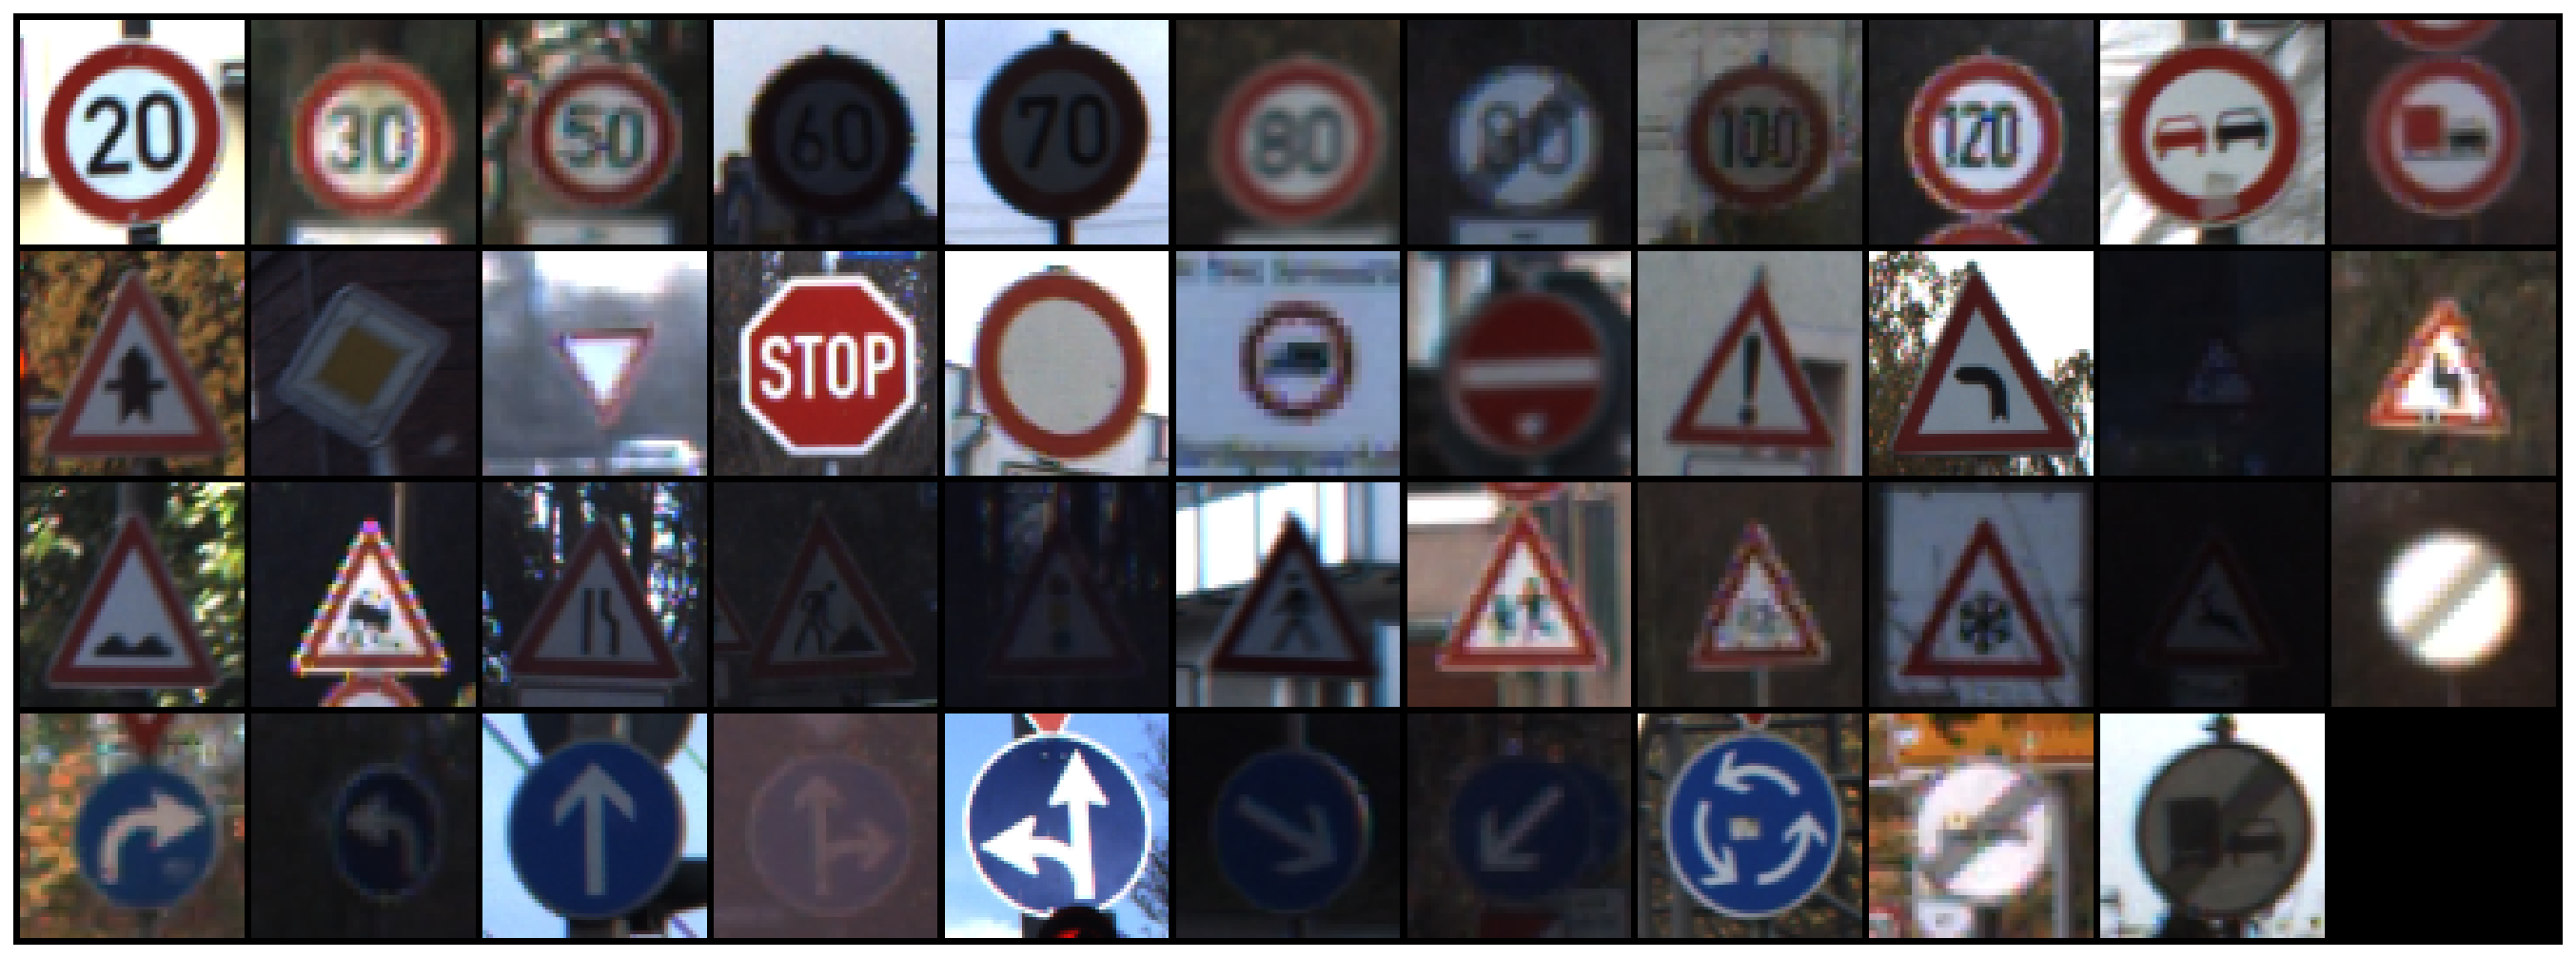

In [32]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

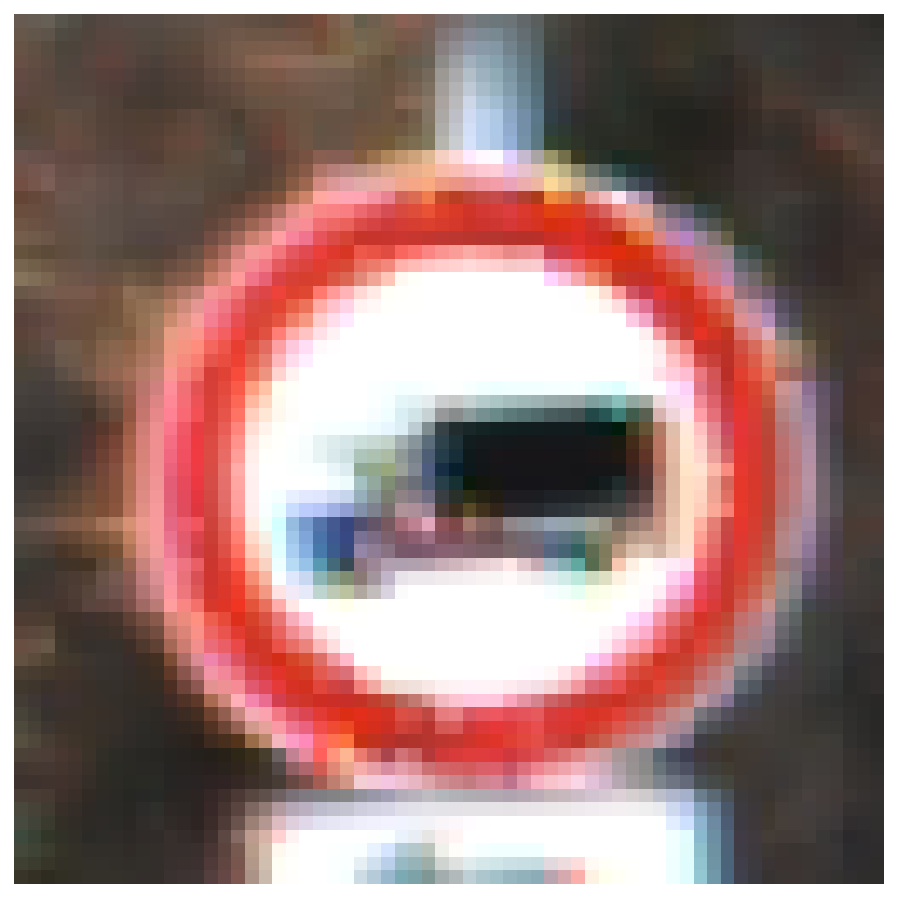

In [34]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building a dataset

Classifying some of the most used traffic signs:

In [35]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

In [39]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [40]:
!tree data --filelimit=100

data
├── test
│   ├── give_way
│   ├── no_entry
│   ├── priority_road
│   └── stop
├── train
│   ├── give_way
│   ├── no_entry
│   ├── priority_road
│   └── stop
└── val
    ├── give_way
    ├── no_entry
    ├── priority_road
    └── stop

15 directories, 0 files


We reserve 80% of the images for training, 10% for validation, and 10% test for each class.

Copy each image to the correct dataset directory:

In [42]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [43]:
!tree data --filelimit=100

data
├── test
│   ├── give_way [405 entries exceeds filelimit, not opening dir]
│   ├── no_entry [209 entries exceeds filelimit, not opening dir]
│   ├── priority_road [405 entries exceeds filelimit, not opening dir]
│   └── stop [141 entries exceeds filelimit, not opening dir]
├── train
│   ├── give_way [2072 entries exceeds filelimit, not opening dir]
│   ├── no_entry [1058 entries exceeds filelimit, not opening dir]
│   ├── priority_road [2020 entries exceeds filelimit, not opening dir]
│   └── stop [740 entries exceeds filelimit, not opening dir]
└── val
    ├── give_way [411 entries exceeds filelimit, not opening dir]
    ├── no_entry [213 entries exceeds filelimit, not opening dir]
    ├── priority_road [401 entries exceeds filelimit, not opening dir]
    └── stop [145 entries exceeds filelimit, not opening dir]

15 directories, 0 files


In [46]:
!ls data/train/stop -U | head -5

00016_00000.ppm
00007_00026.ppm
00009_00022.ppm
00002_00029.ppm
00000_00027.ppm


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}